# __Self-Organising Maps for clustering molecules__

## Requirements for the notebooks
!pip install minisom tqdm rdkit_pypi mols2grid

In [46]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from rdkit import Chem
from rdkit import DataStructs
import numpy as np
from tqdm.auto import tqdm
from minisom import MiniSom
import sys
from time import time
import math
import mols2grid
from ipywidgets import interact
from rdkit.Chem import MACCSkeys, AllChem

# Enable matplotlib in notebook
%matplotlib inline



## Defining a few functions

1. Generate 166-bit MACCS keys
2. Generate Morigan fingerprints
3.  Gnerate a list of fingerprints from a list of smiles


In [47]:
def maccs_fp(mol):
    """
    Generates the MACCS fingerprint for a given molecule.

    Parameters:
    mol (Chem.Mol): The molecule for which the MACCS fingerprint is generated.

    Returns:
    np.array: The MACCS fingerprint as a numpy array of float32 values.
    """
    bv = MACCSkeys.GenMACCSKeys(mol) # bv stands for bit vector
    return np.array([int(x) for x in list(bv.ToBitString())], dtype=np.float32) # can change float32 to float64 or other if needed

def morgan_as_np(mol):
    """
    Convert a molecule to a NumPy array representation using Morgan fingerprints.

    Parameters:
    mol (rdkit.Chem.rdchem.Mol): The input molecule.

    Returns:
    np.ndarray: The NumPy array representation of the molecule.

    """
    bv = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=1024)
    array = np.zeros((1,), dtype=np.float32)
    DataStructs.ConvertToNumpyArray(bv, array)
    return array

def generate_fps(smiles_list, fp_function=maccs_fp):
    """
    Generate fingerprints for a list of SMILES strings.

    Parameters:
    - smiles_list (list): A list of SMILES strings.
    - fp_function (function): The fingerprint function to use. Default is maccs_fp.

    Returns:
    - output_fp_list (list): A list of generated fingerprints.
    """
    output_fp_list = []
    for smiles in tqdm(smiles_list, desc="Generating fingerprints"):
        output_fp_list.append(fp_function(Chem.MolFromSmiles(smiles)))
    return output_fp_list

## __A function to generate a grid pie chart that is adpated from the MiniSom notebook__

link: https://github.com/JustGlowing/minisom/tree/master

The plot will be used to viusalize the distribution between active and non-active compounds

In [67]:
def som_pie_chart(cluster_df, 
                  x_dim=10, 
                  y_dim=10, 
                  x_column="X", 
                  y_column="Y", 
                  activity_column="is_active",
                  color1="orange",
                  color2="blue",
                  color3="green"):
    """
    Generate a SOM (Self-Organizing Map) pie chart based on the given cluster DataFrame.

    Parameters:
    - cluster_df (DataFrame): The cluster DataFrame containing the data.
    - x_dim (int): The number of cells in the x-dimension of the SOM grid. Default is 10.
    - y_dim (int): The number of cells in the y-dimension of the SOM grid. Default is 10.
    - x_column (str): The column name in the DataFrame representing the x-coordinate. Default is "X".
    - y_column (str): The column name in the DataFrame representing the y-coordinate. Default is "Y".
    - activity_column (str): The column name in the DataFrame representing the activity. Default is "is_active".
    - color1 (str): The color for the first category in the pie chart. Default is "orange".
    - color2 (str): The color for the second category in the pie chart. Default is "blue".
    - color3 (str): The color for the third category in the pie chart. Default is "green".

    Returns:
    None
    """
    required_cols = [x_column, y_column, activity_column]
    for col in required_cols:
        if col not in cluster_df.columns:
            # Error if column names are not correct
            print(f"Column '{col}' not found in DataFrame. Please check the column names.", file=sys.stderr)
            sys.exit(1)
        
    cell_dict = {}
    for k, v in [x for x in cluster_df.groupby([x_column, y_column])]:
        cell_dict[k] = Counter(v[activity_column])
        cell_names = cluster_df[x_column].unique()
    
    plt.figure(figsize=(y_dim, x_dim))
    the_grid = GridSpec(x_dim, y_dim)
    for position in cell_dict.keys():
        label_fracs = [cell_dict[position][l] for l in cell_names]
        plt.subplot(the_grid[(x_dim - 1) - position[1], position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)
        
        plt.rcParams['axes.prop_cycle'] = plt.cycler(color=[color1, color2, color3])

### __A function to build a SOM with the package Minisom__

In [49]:
def build_som_minisom(fp_list,
                    x_dim=10,
                    y_dim=10,
                    learning_rate=0.5,
                    sigma=0.3, 
                    num_iters=2000):
    """
    Builds a Self-Organizing Map (SOM) using the MiniSom library.

    Parameters:
    - fp_list (list): A list of feature vectors.
    - x_dim (int): The number of units in the x-dimension of the SOM grid.
    - y_dim (int): The number of units in the y-dimension of the SOM grid.
    - learning_rate (float): The learning rate of the SOM.
    - sigma (float): The standard deviation of the Gaussian neighborhood function.
    - num_iters (int): The number of iterations to train the SOM.

    Returns:
    - x (list): A list of x-coordinates of the best matching units for each feature vector.
    - y (list): A list of y-coordinates of the best matching units for each feature vector.
    """

    print("Building SOM...")
    start_time = time()
    #Building and training SOM
    som = MiniSom(x_dim, 
                  y_dim, 
                  len(fp_list[0]), 
                  sigma=0.3, 
                  learning_rate=0.5, 
                  random_seed=42)
    som.train_random(fp_list, num_iters)
    
    #find best matching units
    print("Finding best matching units...")
    x = []
    y = []
    for row in fp_list:
        x_val, y_val = som.winner(row)
        x.append(x_val)
        y.append(y_val)
    
    elapsed_time = time() - start_time
    print(f"Done.\nElapsed time: {elapsed_time:.2f} seconds")

    return x, y


## __Clustering Data using SOM__



In [50]:
# Download data
url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/dude_erk2_mk01.csv"
df = pd.read_csv(url)
df.head()


,Unnamed: 0,SMILES,ID,is_active
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [51]:
# Adding labels to the dataframe to differentiate 1 and 0 as active and inactive
df["activity_label"] = ["active" if x == 1 else "inactive" for x in df["is_active"]]

# Counting the number of active vs inactive molecules
df["activity_label"].value_counts()

activity_label
inactive    4550
active        79
Name: count, dtype: int64

In [61]:
# Generate fingerprints and build SOM by functions built at the start of the notebook

# Setting paramters for SOM
morgan_list = generate_fps(df.SMILES, morgan_as_np)
x_dim = 10 #default is 10 for som_pie_chart and build_som_minisom
y_dim = 10 # default is 10 for som_pie_chart and build_som_minisom

# Building SOM
morgan_x, morgan_y = build_som_minisom(morgan_list, x_dim, y_dim)

# Adding coordinates to the dataframe
df["morgan_x"] = morgan_x
df["morgan_y"] = morgan_y

Generating fingerprints:   0%|          | 0/4629 [00:00<?, ?it/s]

Building SOM...
Finding best matching units...
Done.
Elapsed time: 2.12 seconds


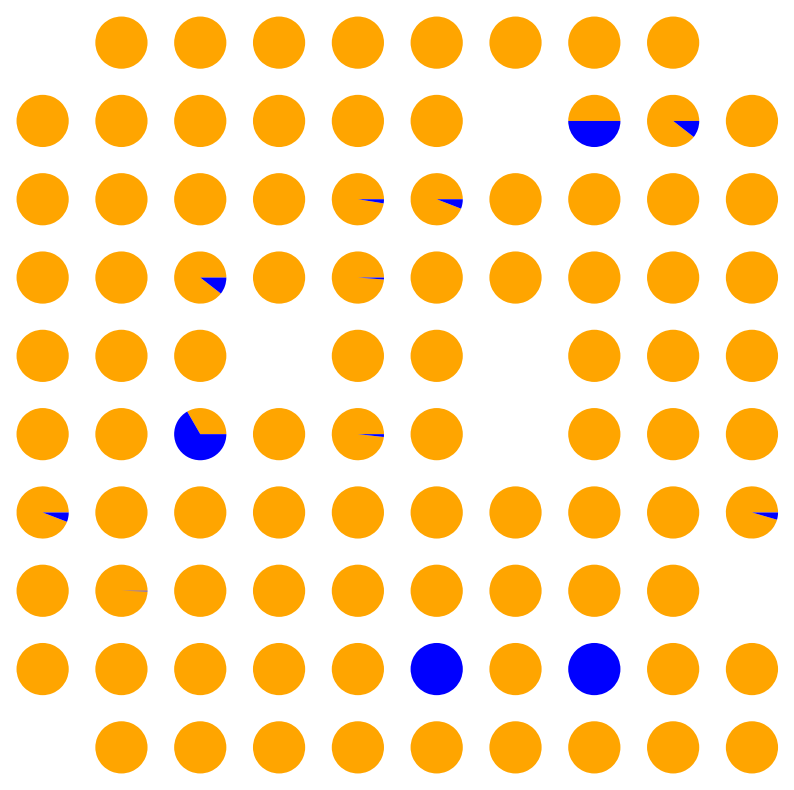

In [62]:
# Plotting the SOM
som_pie_chart(df, 
              x_dim, 
              y_dim, 
              x_column="morgan_x", 
              y_column="morgan_y", 
              )

#### Creating an Interactive Viewer
Let's define a function that will display the molecules in a particular cell.  We'll use the Jupyter [interact](https://colab.research.google.com/github/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Using%20Interact.ipynb) widget to make an interactive tool.  Note that cells are numbered from 0, with cell (0,0) in the bottom left corner. 

In [ ]:
# Creating a interactive viewer
@interact(x=range(0,x_dim), y=range(0,y_dim))
def display_mols(x, y):
    return mols2grid.display(df.query("morgan_x==@x and morgan_y==@y"),subset=["img","ID","activity_label"])

In [69]:
# Generate fingerprints and build SOM by functions built at the start of the notebook

# Setting paramters for SOM with MACCS
macss_list = generate_fps(df.SMILES)
x_dim = 10 #default is 10 for som_pie_chart and build_som_minisom
y_dim = 10 # default is 10 for som_pie_chart and build_som_minisom

# Building SOM
macss_x, macss_y = build_som_minisom(macss_list, x_dim, y_dim)

# Adding coordinates to the dataframe
df["macss_x"] = macss_x
df["macss_y"] = macss_y


Generating fingerprints:   0%|          | 0/4629 [00:00<?, ?it/s]

Building SOM...
Finding best matching units...
Done.
Elapsed time: 0.55 seconds


In [70]:
df.head()

,Unnamed: 0,SMILES,ID,is_active,activity_label,morgan_x,morgan_y,macss_x,macss_y
0,0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1,active,2,6,1,6
1,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1,active,9,3,1,6
2,2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1,active,7,1,1,8
3,3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1,active,7,1,1,8
4,4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1,active,7,1,1,8


In [71]:
#Not working!!!
# Plotting the SOM
som_pie_chart(df, 
              x_dim, 
              y_dim, 
              x_column="macss_x", 
              y_column="macss_y", 
              )

/Users/luke_zondagh_m1/Softwares/miniforge3/envs/PatWalters_tutorial/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3232: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

ValueError: need at least one array to concatenate

<Figure size 1000x1000 with 7 Axes>